In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/human-face-emotions
/kaggle/input/human-face-emotions/Data
/kaggle/input/human-face-emotions/Data/Fear
/kaggle/input/human-face-emotions/Data/Suprise
/kaggle/input/human-face-emotions/Data/Angry
/kaggle/input/human-face-emotions/Data/Sad
/kaggle/input/human-face-emotions/Data/Happy


# Loading the Dataset using PyTorch


In [3]:


data_dir = "/kaggle/input/human-face-emotions/Data"

transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()
                               ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size= 32, shuffle= True)




In [4]:
print(dataset.classes)
print(dataset.class_to_idx)
print(f"Dataset Size = {len(dataset)}")


['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Sad': 3, 'Suprise': 4}
Dataset Size = 59099


## Lets look at a sample

In [5]:
image, label = dataset[31242]
print(f"Image shape = {image.shape}")
print(f"Image Label = {label}")
print(f"Label Name = {dataset.classes[label]}")

Image shape = torch.Size([3, 128, 128])
Image Label = 2
Label Name = Happy


## Visualize a few Examples

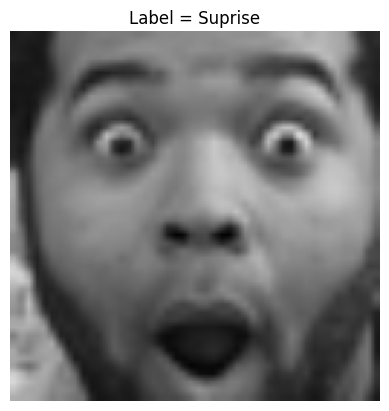

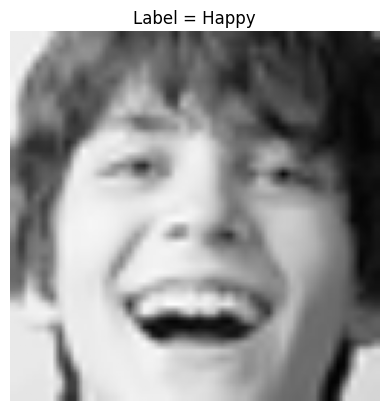

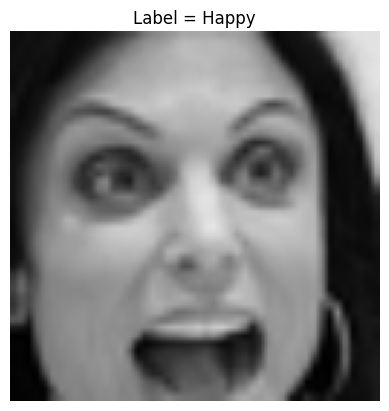

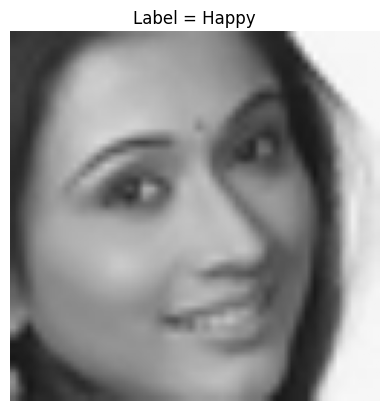

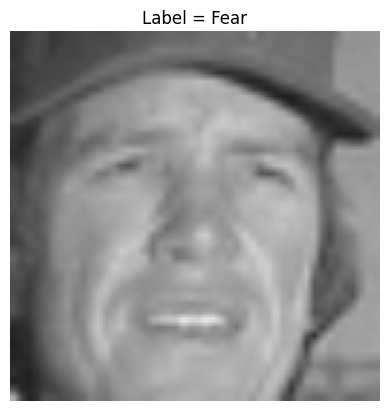

In [6]:
def show_image(img,label):
    img = img.permute(1,2,0).numpy()
    plt.imshow(img)
    plt.title(f"Label = {dataset.classes[label]}")
    plt.axis("off")
    plt.show()

for i in range(5):
    num = random.randint(1, len(dataset))
    image, label = dataset[i + num]
    show_image(image, label)


# Split the Dataset

In [7]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size = {len(train_dataset)}")
print(f"Validation size = {len(val_dataset)}")
print(f"Test size = {len(test_dataset)}")

Train size = 41369
Validation size = 8864
Test size = 8866


## Create DataLoaders for all Sets

In [8]:
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = True)

# Training Setup

In [9]:
class EmotionClassify_CNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionClassify_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3, padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 32 *32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Instantiate

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassify_CNN(num_classes= len(dataset.classes)).to(device)

### Setup the Loss and optimizer


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

## Actual Training 

In [12]:
from tqdm import tqdm
import time

num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    # Wrap the DataLoader with tqdm
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm with current loss
        loop.set_postfix(loss=running_loss / (loop.n + 1))

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.1f}s, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10: 100%|██████████| 1293/1293 [08:11<00:00,  2.63it/s, loss=1.39]


Epoch 1 completed in 491.7s, Loss: 1.3949


Epoch 2/10: 100%|██████████| 1293/1293 [04:04<00:00,  5.29it/s, loss=1.16]


Epoch 2 completed in 244.4s, Loss: 1.1562


Epoch 3/10: 100%|██████████| 1293/1293 [03:48<00:00,  5.66it/s, loss=0.978]


Epoch 3 completed in 228.3s, Loss: 0.9777


Epoch 4/10: 100%|██████████| 1293/1293 [03:45<00:00,  5.73it/s, loss=0.81] 


Epoch 4 completed in 225.6s, Loss: 0.8105


Epoch 5/10: 100%|██████████| 1293/1293 [03:42<00:00,  5.80it/s, loss=0.657]


Epoch 5 completed in 222.9s, Loss: 0.6567


Epoch 6/10: 100%|██████████| 1293/1293 [03:45<00:00,  5.74it/s, loss=0.534]


Epoch 6 completed in 225.4s, Loss: 0.5342


Epoch 7/10: 100%|██████████| 1293/1293 [03:44<00:00,  5.75it/s, loss=0.445]


Epoch 7 completed in 224.8s, Loss: 0.4446


Epoch 8/10: 100%|██████████| 1293/1293 [03:37<00:00,  5.95it/s, loss=0.378]


Epoch 8 completed in 217.3s, Loss: 0.3779


Epoch 9/10: 100%|██████████| 1293/1293 [03:35<00:00,  6.01it/s, loss=0.327]


Epoch 9 completed in 215.2s, Loss: 0.3272


Epoch 10/10: 100%|██████████| 1293/1293 [03:36<00:00,  5.96it/s, loss=0.294]

Epoch 10 completed in 216.9s, Loss: 0.2944


In [17]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # make sure this matches below
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy = {100 * correct / total:.2f}%")


Validation Accuracy = 79.77%


# Saving for later use


In [14]:
torch.save(model.state_dict(), "emotion_cnn.pth")

In [15]:
model = EmotionClassify_CNN(num_classes = len(dataset.classes)).to(device)

model.load_state_dict(torch.load("emotion_cnn.pth", map_location=device))
model.eval()

EmotionClassify_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)